# LoRA Fine-Tuning with Hugging Face and TensorFlow on ProsusAI/finbert

## 1. Importing required libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
from torch import nn
import optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Mount drive [Only for Google Colab]
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


## 2. Loading the dataset

In [ ]:
df = pd.read_csv('../data/processed/financial_news_combined_phrasebank.csv')


## 3. Define Split Strategy and Prepare Data

In [5]:
# Define split ratios for training and validation only
# - 80% for training
# - 20% for validation
TRAIN_SIZE = 0.80
VAL_SIZE = 0.20

# Prepare features and labels
X = df['text']
y = df['target_sentiment']

# Create label mappings
labels = ['Positive', 'Negative', 'Neutral']
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Convert string labels to integers
y_encoded = y.map(label2id)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=VAL_SIZE,
    stratify=y_encoded,
    random_state=42
)
print(f"Encoded Label: {label2id}")
#print class distribution in training and validation set
print("Class distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in validation set:")
print(y_val.value_counts())
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")

Encoded Label: {'Positive': 0, 'Negative': 1, 'Neutral': 2}
Class distribution in training set:
target_sentiment
0    4378
1    3594
2    3000
Name: count, dtype: int64

Class distribution in validation set:
target_sentiment
0    1095
1     898
2     750
Name: count, dtype: int64
Training set: 10972 samples (80.0%)
Validation set: 2743 samples (20.0%)


## 4. Preprocess the dataset for input into the model

In [6]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"

# Convert splits to Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
val_dataset = Dataset.from_dict({'text': X_val.tolist(), 'label': y_val.tolist()})

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10972 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/2743 [00:00<?, ? examples/s]

## 5. Loading and applying LoRA to the model

In [7]:
# Create LoRA config
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Sequence Classification
    r=4,                        # Rank of the update matrices
    lora_alpha=32,              # Alpha parameter for scaling
    lora_dropout=0.1,           # Dropout probability
    bias="none",                # No bias training
    target_modules=["query", "key", "value"] # Target modules to apply LoRA
)

# Applies LoRA to the model
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 223,491 || all params: 110,076,678 || trainable%: 0.2030


## 6. Creating custom WeightedLossTrainer to handle imbalance Class weights




In [8]:
# Encoded Label: {'Positive': 0, 'Negative': 1, 'Neutral': 2}
# Count samples per class
class_counts = [4378, 3594, 3000]
total_samples = sum(class_counts)
# Calculate weights as the inverse of the class frequency
weights = [total_samples / count for count in class_counts]
# Normalize weight
min_weight = min(weights)
normalized_weights = [w / min_weight for w in weights]
# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(normalized_weights).cuda()
print("Classes: [Positive, Negative, Neutral]")
print(f"Samples per classes: {class_counts}")
print(f"Calculated and normalized weights: {normalized_weights}")
print(f"Weight Tensor on GPU: {class_weights_tensor}")

Classes: [Positive, Negative, Neutral]
Samples per classes: [4378, 3594, 3000]
Calculated and normalized weights: [1.0, 1.218141346688926, 1.4593333333333331]
Weight Tensor on GPU: tensor([1.0000, 1.2181, 1.4593], device='cuda:0')


In [9]:
# Custom Trainer class to use pre-calculated class weights
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Get labels from inputs
        labels = inputs.pop("labels")

        # Get model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define loss function
        # Tensor receive pre-calculated class weights
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

        # Calculating loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

## 7. Define a custom function to compute metrics

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

## 8. Finding the best Hyperparameter with Optuna

In [ ]:
# Function to initialize model
def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased",
        num_labels=3,
    )

# Function to define hyperparameters to test with Optuna
def optuna_hp_space(trial: optuna.Trial):
    return {
        # We are going to find the best combination for learning_rate and weight_decay parameters
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [3, 4]),
    }

test_training_args = TrainingArguments(
    output_dir="./tests/optuna_search",
    eval_strategy="epoch", # Evaluar al final de cada época es eficiente para la búsqueda
    save_strategy="epoch",
    num_train_epochs=3, # Mantén 3 épocas para cada prueba
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    fp16=True,
    logging_steps=100,
    load_best_model_at_end=True,
    report_to="none",
)

optuna_trainer = WeightedLossTrainer(
    args=test_training_args,
    model_init=model_init,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
)

best_trial = optuna_trainer.hyperparameter_search(
    direction="maximize",         # Maximize F1-score
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=15,                  # Combinations of hyperparemeters to test (15 in this case)
    compute_objective=lambda metrics: metrics["eval_f1"], # Metric to optimize
)

print("Hyperparameters Tuning:")
print(f"Best F1-score: {best_trial.objective}")
print("Best hyperparameters found:")
for param, value in best_trial.hyperparameters.items():
    print(f"  -> {param}: {value}")

/tmp/ipython-input-2805656294.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-23 14:01:24,269] A new study created in memory with name: no-name-e3e4f76d-a06b-4db8-bcce-e25a6c83149e
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a dow

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.518700,0.483617,0.802406,0.802059
2,0.334500,0.476610,0.822822,0.822903
3,0.211300,0.555589,0.828655,0.828649


[I 2025-08-23 14:05:47,731] Trial 0 finished with value: 0.828648520822601 and parameters: {'learning_rate': 2.366321123413612e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.518500,0.488073,0.806052,0.805688
2,0.353000,0.466855,0.828290,0.828355
3,0.230300,0.527565,0.821363,0.821231


[I 2025-08-23 14:11:33,594] Trial 1 finished with value: 0.8212314427804118 and parameters: {'learning_rate': 1.9755637498494708e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.519000,0.482833,0.804958,0.804569
2,0.332600,0.477191,0.822093,0.822195
3,0.208900,0.559180,0.828290,0.828293


[I 2025-08-23 14:17:40,090] Trial 2 finished with value: 0.8282930363583777 and parameters: {'learning_rate': 2.4283200486628365e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.533400,0.497194,0.795479,0.795205
2,0.387900,0.470493,0.819541,0.819639
3,0.288000,0.501487,0.816989,0.816860


[I 2025-08-23 14:23:38,122] Trial 3 finished with value: 0.8168603485407597 and parameters: {'learning_rate': 1.3646326237061225e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.514100,0.476189,0.799854,0.799388
2,0.287800,0.506277,0.818082,0.818092
3,0.133900,0.658718,0.827561,0.827584


[I 2025-08-23 14:30:37,122] Trial 4 finished with value: 0.8275841627261441 and parameters: {'learning_rate': 4.5723790490851714e-05, 'weight_decay': 0.0}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.530900,0.496275,0.797667,0.797395


[I 2025-08-23 14:31:54,535] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.514500,0.474146,0.805323,0.804799
2,0.304200,0.487000,0.826467,0.826497
3,0.166900,0.620041,0.826467,0.826516


[I 2025-08-23 14:37:19,321] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.519100,0.484185,0.803500,0.803202
2,0.337000,0.474949,0.823915,0.823990
3,0.212300,0.549646,0.827561,0.827522


[I 2025-08-23 14:42:11,736] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.551800,0.506964,0.792927,0.792952


[I 2025-08-23 14:43:28,893] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.515200,0.473287,0.806781,0.806246
2,0.319100,0.477623,0.821363,0.821366


[I 2025-08-23 14:46:13,679] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.523500,0.491339,0.801677,0.801190


[I 2025-08-23 14:47:30,907] Trial 10 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.515300,0.478428,0.807145,0.806845
2,0.324800,0.474928,0.824645,0.824705
3,0.196300,0.572772,0.828290,0.828307


[I 2025-08-23 14:53:44,732] Trial 11 finished with value: 0.8283068827350161 and parameters: {'learning_rate': 2.6507677472157748e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.828648520822601.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.516900,0.477733,0.808604,0.808400
2,0.324200,0.475375,0.825738,0.825826
3,0.191600,0.578055,0.829748,0.829735


[I 2025-08-23 14:59:58,717] Trial 12 finished with value: 0.8297348553612626 and parameters: {'learning_rate': 2.7611971981612025e-05, 'weight_decay': 0.1}. Best is trial 12 with value: 0.8297348553612626.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.514500,0.473069,0.806781,0.806323
2,0.306300,0.491639,0.825374,0.825412
3,0.167900,0.624222,0.826103,0.826163


[I 2025-08-23 15:05:24,276] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.515800,0.479531,0.802042,0.801057


[I 2025-08-23 15:06:42,088] Trial 14 pruned. 


Hyperparameters Tuning:
Best F1-score: 0.8297348553612626
Best hyperparameters found:
  -> learning_rate: 2.7611971981612025e-05
  -> weight_decay: 0.1


## 9. Train the model using the optimal hyperparameters suggested by Optuna.



In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./tests/model_training_out/beto-lora",
    # Optimal Hyperparameters
    learning_rate=2.7611971981612025e-05,
    weight_decay=0.1,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # Training management
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_total_limit=1,

    # Others optional [but suggested] arguments [for google colab]
    fp16=True,
    report_to="none",
)

# Create Trainer instance
# Testing model perform with custom loss function.
trainer = WeightedLossTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor # Setting tensor with the pre-calculated weights
)

#Train the model
print("Starting training...")
trainer.train()
print("Training finished.")

/tmp/ipython-input-2805656294.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.619800,0.600610,0.751003,0.748723
2,0.582800,0.579702,0.761575,0.760184
3,0.570400,0.573442,0.764127,0.763070


Training finished.


## 7. Evaluating the Model

In [17]:
# Evaluating the trainer
eval_results = trainer.evaluate()
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print("\n--- Evaluation Results ---")
for key, value in eval_results.items():
    print(f"{key}: {value}")

Validation Accuracy: 0.7641

--- Evaluation Results ---
eval_loss: 0.5734423398971558
eval_accuracy: 0.7641268683922713
eval_f1: 0.7630695729132576
eval_runtime: 5.8065
eval_samples_per_second: 472.404
eval_steps_per_second: 14.811
epoch: 3.0


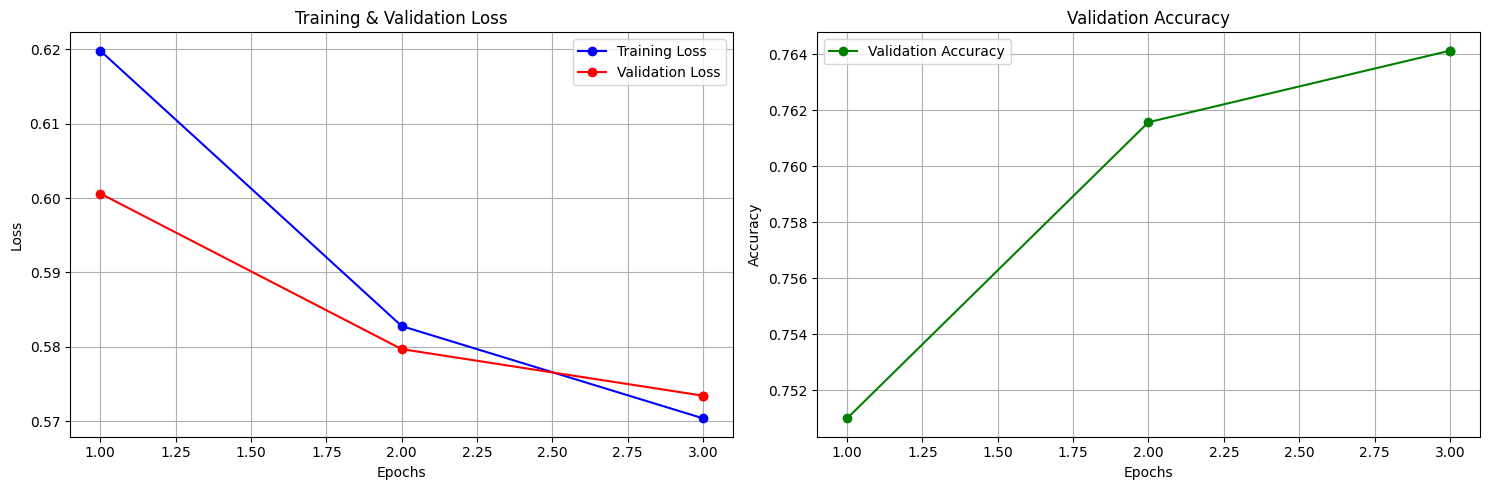

In [19]:
# Plotting Loss and Accuracy Curves
# Extracting history
log_history = trainer.state.log_history
# Get training and evaluation logs
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]
# Extract data for plotting
train_epochs = [log['epoch'] for log in train_logs]
train_loss = [log['loss'] for log in train_logs]
eval_epochs = [log['epoch'] for log in eval_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]
eval_accuracy = [log['eval_accuracy'] for log in eval_logs]
# Setting the figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plotting training and validation loss
ax1.plot(train_epochs, train_loss, 'b-o', label='Training Loss')
ax1.plot(eval_epochs, eval_loss, 'r-o', label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
# Plotting validation accuracy
ax2.plot(eval_epochs, eval_accuracy, 'g-o', label='Validation Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

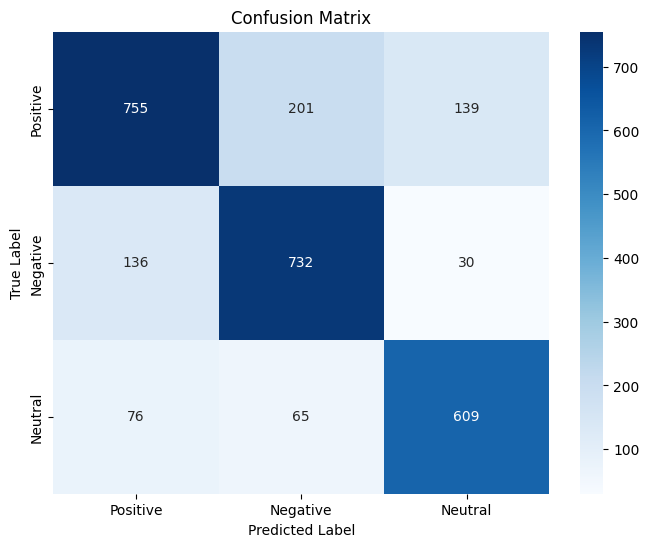

In [20]:
# Plotting Confusion Matrix
predictions = trainer.predict(tokenized_val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
actual_labels = y_val.to_numpy()
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
# Displaying Classification Report
report = classification_report(actual_labels, predicted_labels, target_names=labels, output_dict=True)
print(classification_report(actual_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    Positive       0.78      0.69      0.73      1095
    Negative       0.73      0.82      0.77       898
     Neutral       0.78      0.81      0.80       750

    accuracy                           0.76      2743
   macro avg       0.77      0.77      0.77      2743
weighted avg       0.77      0.76      0.76      2743



## Saving the model

In [ ]:
trainer.save_model("../src/llm/finbeto-lora")
print("Model saved!")

Model saved!
